# The Meaning of a word can be inferred by the company it Keeps
# " Show me your friends and i ll tell who are you".

In [ ]:

import gensim
import re
import pandas as pd
from time import time
from collections import defaultdict
import spacy
import logging

In [ ]:
# The Secret to get word2vec is by having a lot and lots of text data.

In [ ]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", 
                    datefmt= '%H:%M:%S', 
                    level=logging.INFO)

In [ ]:
df = pd.read_csv('simpsons_dataset.csv')

In [ ]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
df.isnull().sum()

raw_character_text    16085
spoken_words          24077
dtype: int64

In [ ]:
# Remooving missing values
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [ ]:
# cleaning
#Diabeling Named entity recognition for speed
nlp = spacy.load('en', disable=['ner', 'parser'])
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt) 

In [ ]:
#Removes non-alphabetic characters:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [ ]:
# Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.93 mins


In [ ]:
# Put the results in a DataFrame to remove missing values and duplicates:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(77393, 1)

In [ ]:
# We are using Gensim Phrases package to automatically detect common 
# phrases (bigrams) from a list of sentences.
# The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
# As Phrases() takes a list of list of words as input:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
# Creates the relevant phrases from the list of sentences:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 08:50:01: collecting all words and their counts
INFO - 08:50:01: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 08:50:01: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 08:50:01: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 08:50:01: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 08:50:01: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 08:50:01: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 08:50:02: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 08:50:02: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 08:50:02: collected 303406 word types from a corpus of 481866 words (unigram + bigrams) and 77393 sentences
INFO - 08:50:02: using 303406 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=

In [ ]:
# The goal of Phraser() is to cut down memory consumption of Phrases(), 
# by discarding model state not strictly needed for the bigram detection task:
bigram = Phraser(phrases)

INFO - 08:52:01: source_vocab length 303406
INFO - 08:52:03: Phraser built with 108 phrasegrams


In [ ]:
# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [ ]:
# checking for most frequent words:
# check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

28789

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'look', 'right', 'want', 'come']

Training the model

In [ ]:
# using Gensim implementation of word2vec
import multiprocessing
from gensim.models import Word2Vec

we will separate the training in 3 distinctive steps for clarity and monitoring.
1.Word2Vec():
In this first step, set up the parameters of the model one-by-one.
we do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.
2.build_vocab():
it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, we can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3.train():
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [ ]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count()


In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 09:10:46: collecting all words and their counts
INFO - 09:10:46: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:10:46: PROGRESS: at sentence #10000, processed 61795 words, keeping 9543 word types
INFO - 09:10:46: PROGRESS: at sentence #20000, processed 127517 words, keeping 14491 word types
INFO - 09:10:46: PROGRESS: at sentence #30000, processed 188069 words, keeping 17603 word types
INFO - 09:10:46: PROGRESS: at sentence #40000, processed 243639 words, keeping 20368 word types
INFO - 09:10:47: PROGRESS: at sentence #50000, processed 303575 words, keeping 22861 word types
INFO - 09:10:47: PROGRESS: at sentence #60000, processed 364391 words, keeping 25182 word types
INFO - 09:10:47: PROGRESS: at sentence #70000, processed 425922 words, keeping 27383 word types
INFO - 09:10:47: collected 28789 word types from a corpus of 470437 raw words and 77393 sentences
INFO - 09:10:47: Loading a fresh vocabulary
INFO - 09:10:47: effective_min_count=20 retains 30

Time to build vocab: 0.03 mins


In [ ]:
#Training of the model:
#Parameters of the training:

total_examples = int #Count of sentences;
epochs = int  #Number of iterations (epochs) over the corpus - [10, 20, 30]

In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 09:14:04: training model with 1 workers on 3079 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 09:14:05: EPOCH 1 - PROGRESS: at 41.49% examples, 72236 words/s, in_qsize 0, out_qsize 0
INFO - 09:14:06: EPOCH 1 - PROGRESS: at 91.28% examples, 77174 words/s, in_qsize 1, out_qsize 0
INFO - 09:14:06: worker thread finished; awaiting finish of 0 more threads
INFO - 09:14:06: EPOCH - 1 : training on 470437 raw words (173882 effective words) took 2.2s, 78462 effective words/s
INFO - 09:14:07: EPOCH 2 - PROGRESS: at 43.68% examples, 76754 words/s, in_qsize 0, out_qsize 0
INFO - 09:14:08: EPOCH 2 - PROGRESS: at 91.28% examples, 78883 words/s, in_qsize 0, out_qsize 0
INFO - 09:14:09: worker thread finished; awaiting finish of 0 more threads
INFO - 09:14:09: EPOCH - 2 : training on 470437 raw words (174094 effective words) took 2.2s, 79377 effective words/s
INFO - 09:14:10: EPOCH 3 - PROGRESS: at 46.07% examples, 77557 words/s, in_qsize 0, out_qsize 0


Time to train the model: 1.11 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [ ]:
w2v_model.init_sims(replace=True)

INFO - 09:16:31: precomputing L2-norms of word weight vectors


In [ ]:
# exploring the model
# we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.828229546546936),
 ('grownup', 0.806647777557373),
 ('sweetheart', 0.8045774102210999),
 ('apu', 0.8008295893669128),
 ('rude', 0.7986841797828674),
 ('happen', 0.7937724590301514),
 ('duh', 0.7891429662704468),
 ('nervous', 0.7866657376289368),
 ('drunk', 0.786217451095581),
 ('snuggle', 0.7835480570793152)]

A small precision here:
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do not necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [ ]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.8391463160514832),
 ('robert', 0.835328221321106),
 ('select', 0.8307275772094727),
 ('recent', 0.8266687393188477),
 ('pleased', 0.8199465274810791),
 ('elect', 0.8168405294418335),
 ('committee', 0.8150883913040161),
 ('ceremony', 0.8137437105178833),
 ('threat', 0.811286449432373),
 ('attorney', 0.8100112676620483)]

In [ ]:
# What about Marge now?
w2v_model.wv.most_similar(positive=["marge"])

[('sorry', 0.8429554104804993),
 ('sweetheart', 0.8336213827133179),
 ('homer', 0.8282296061515808),
 ('homie', 0.817916989326477),
 ('snuggle', 0.8154658079147339),
 ('rude', 0.8148587346076965),
 ('fault', 0.8146848678588867),
 ('normally', 0.8027015924453735),
 ('have', 0.8005430102348328),
 ('ralphie', 0.7990739941596985)]

In [ ]:
# lets check bart now:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8552330732345581),
 ('mom_dad', 0.84839928150177),
 ('concerned', 0.8459775447845459),
 ('surprised', 0.8376045227050781),
 ('mom', 0.83631432056427),
 ('bedtime', 0.8329649567604065),
 ('worried', 0.8298053741455078),
 ('selfish', 0.826146125793457),
 ('convince', 0.8253860473632812),
 ('pregnant', 0.8251398801803589)]

In [ ]:
# Similarities:
# Here, we will see how similar are two words to each other :

In [ ]:
w2v_model.wv.similarity("maggie", 'baby')

0.74583334

In [ ]:
w2v_model.wv.similarity('bart', 'nelson')

0.6850492

Odd-One-Out:¶
Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [ ]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])


WARNING - 09:30:16: vectors for words {'kearney'} are not present in the model, ignoring these words
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jimbo'

In [ ]:
# t-SNE visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=2).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

10 Most similar words vs. 8 Random words:¶
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


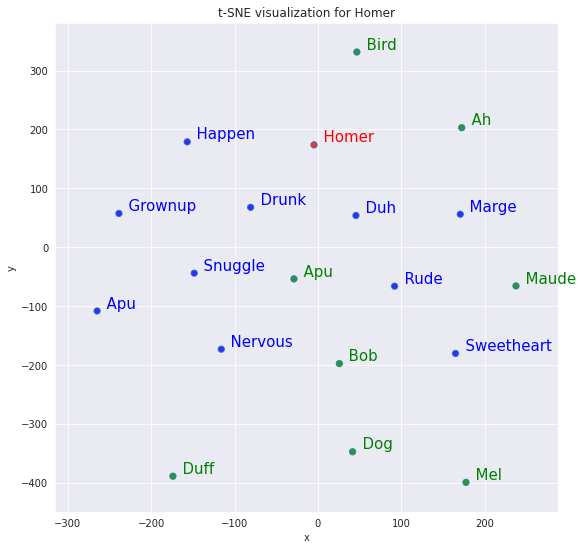

In [ ]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

10 Most similar words vs. 10 Most dissimilar
This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


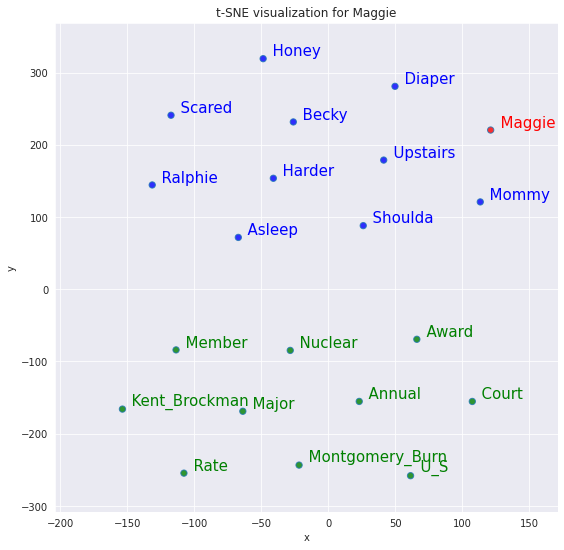

In [ ]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])